In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import urllib.request

In [2]:
import urllib.request
url = 'http://covidtracking.com/api/states/daily.csv'
urllib.request.urlretrieve(url, '/Users/blengerich/Desktop/states-daily.csv')

('/Users/blengerich/Desktop/states-daily.csv',
 <http.client.HTTPMessage at 0x11ae3f490>)

In [3]:
df = pd.read_csv("~/Desktop/states-daily.csv", sep=',', header=0)
df_vals = df.values
print(df.shape)
df.head()

(2676, 25)


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200422,AK,335.0,11824.0,NaN,39.0,36.0,NaN,NaN,NaN,...,36.0,12159.0,12159.0,12159.0,2,0.0,0.0,1034.0,6.0,1040.0
1,20200422,AL,5465.0,43295.0,NaN,NaN,730.0,NaN,288.0,NaN,...,730.0,48760.0,48760.0,48760.0,1,17.0,31.0,0.0,234.0,234.0
2,20200422,AR,2276.0,27437.0,NaN,97.0,291.0,NaN,NaN,23.0,...,291.0,29713.0,29713.0,29713.0,5,-1.0,0.0,2223.0,49.0,2272.0
3,20200422,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200422,AZ,5459.0,51142.0,NaN,664.0,NaN,300.0,NaN,195.0,...,NaN,56601.0,56601.0,56601.0,4,21.0,0.0,1241.0,208.0,1449.0


In [4]:
def get_date_format(day, month, year):
    return year*1e4 + month*1e2 + day

def get_idx(state, date):
    i = np.where(df_vals[:, df.columns.tolist().index('state')] == state)[0]
    j = np.where(df_vals[:, df.columns.tolist().index('date')] == date)[0]
    return set(i).intersection(set(j)).pop()
    
def get_val(state, date, col_name):
    idx = get_idx(state, date)
    return df[[col_name]].values[idx]

def get_positive(state, date):
    return get_val(state, date, 'positive')

def get_negative(state, date):
    return get_val(state, date, 'negative')

def get_total(state, date):
    return get_val(state, date, 'total')

In [5]:
def calc_sum_z(N, num_pos, num_neg, c):
    #return (num_pos * N * c0) / (c1*num_tests + (c0-c1)*num_pos)#(num_tests - (1 - c1)*num_pos)
    try:
        return (N*num_pos) / (c*num_neg + num_pos)
    except:
        return (N*num_pos) / (c(N, num_pos, num_neg)*num_neg + num_pos)

state_pops = {
    'PA': 12.8e6,
    'NY': 19.5e6,
    'CA': 39.5e6,
    'MD': 6e6,
    'VA': 8.5e6,
    'TX': 29e6,
    'FL': 21e6,
    'WA': 7.5e6
}
def get_latent_total(state, date, c):
    return calc_sum_z(state_pops[state], get_positive(state, date), get_negative(state, date), c)

In [6]:
def readable_date(date):
    return "{:.0f}/{:.0f}".format((date % 1e4 - date % 1e2)/1e2, date % 1e2)

plt.rcParams.update({'font.size': 26})
#begin_day = 11 # Mar 11
#end_day = 31 # Mar 26

dates = [get_date_format(d, 3, 2020) for d in range(16, 32)]
dates.extend([get_date_format(d, 4, 2020) for d in range(1, 23)])
readable_dates = list(map(readable_date, dates))
print(readable_dates)

['3/16', '3/17', '3/18', '3/19', '3/20', '3/21', '3/22', '3/23', '3/24', '3/25', '3/26', '3/27', '3/28', '3/29', '3/30', '3/31', '4/1', '4/2', '4/3', '4/4', '4/5', '4/6', '4/7', '4/8', '4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16', '4/17', '4/18', '4/19', '4/20', '4/21', '4/22']


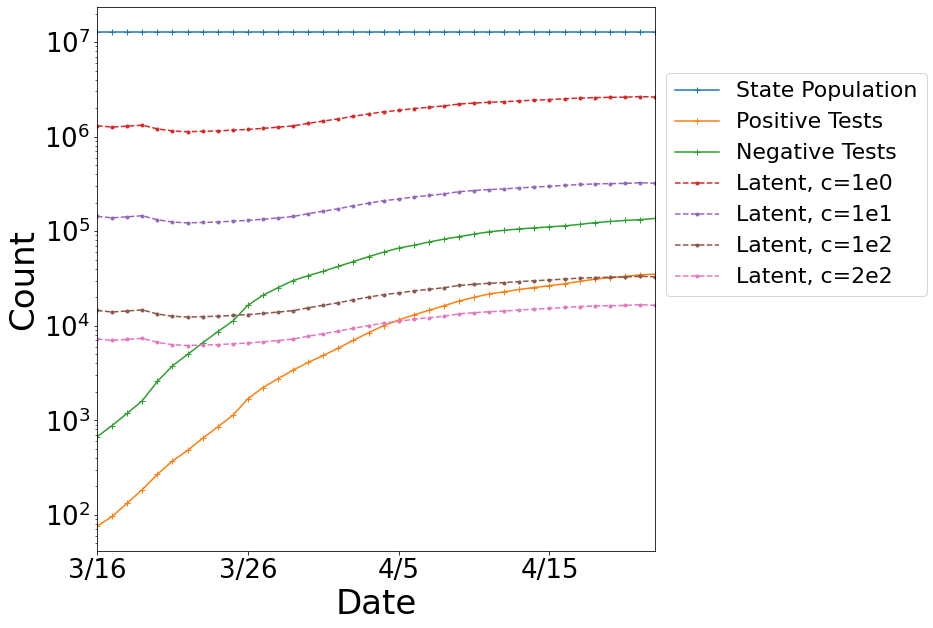

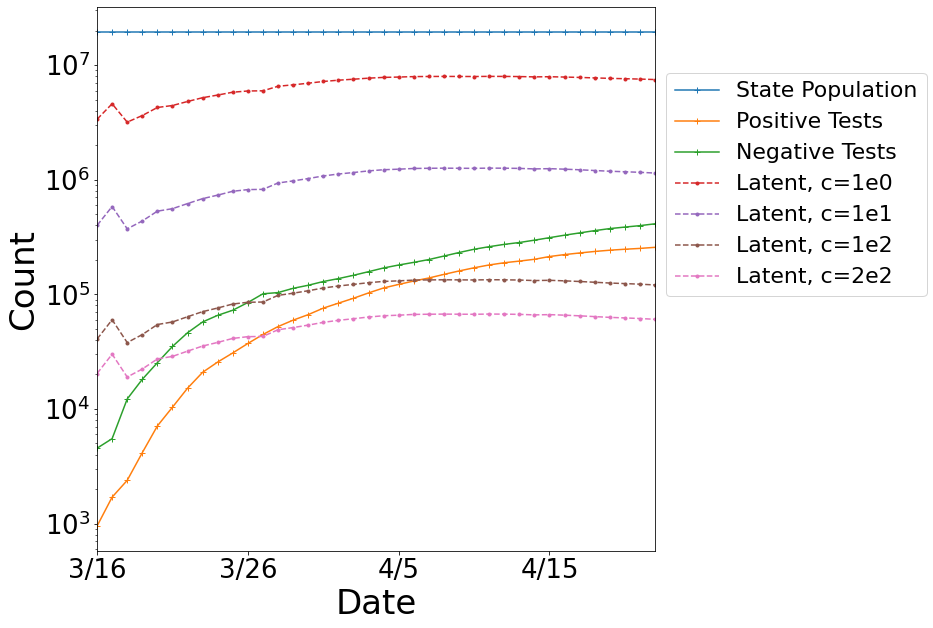

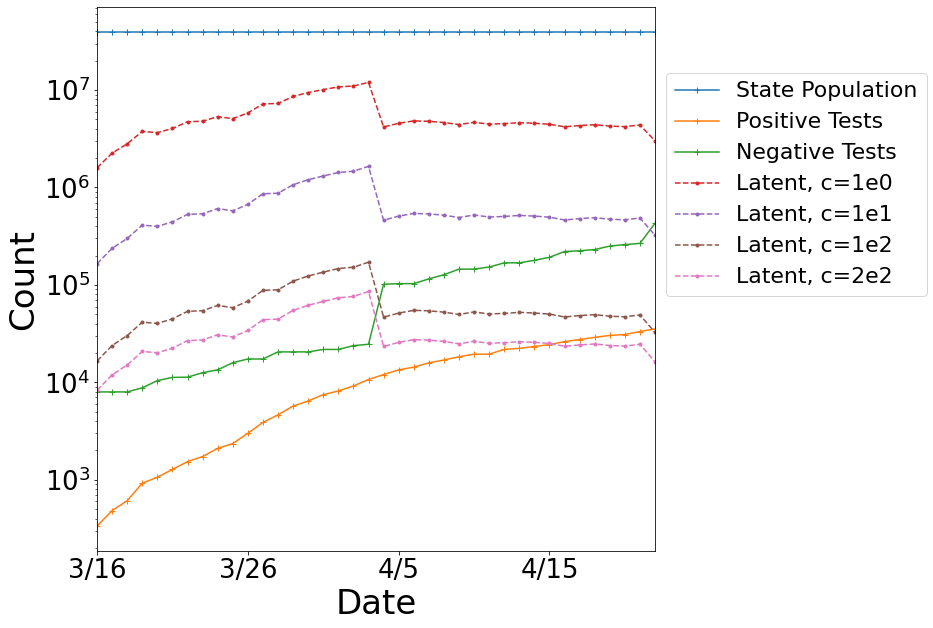

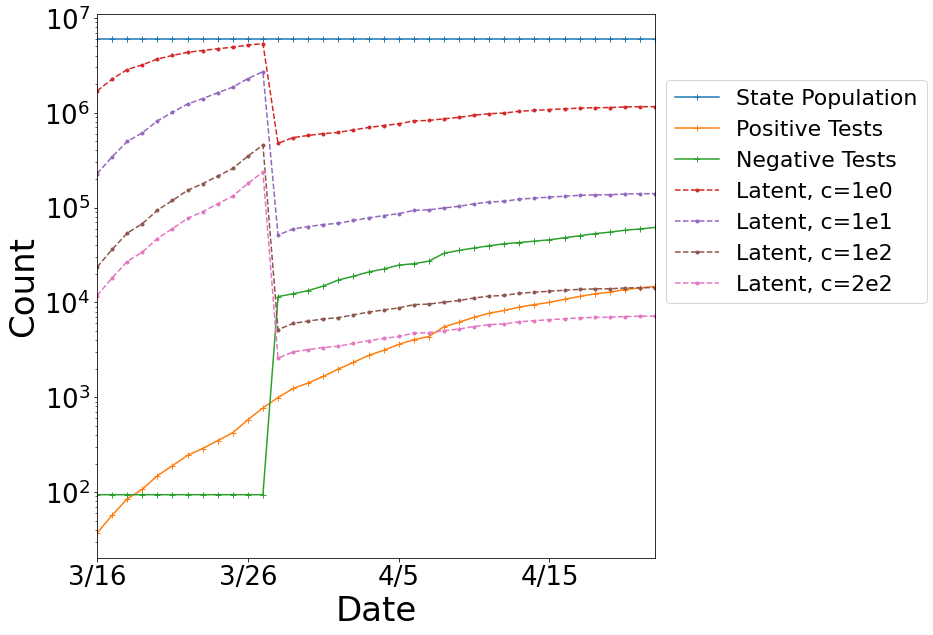

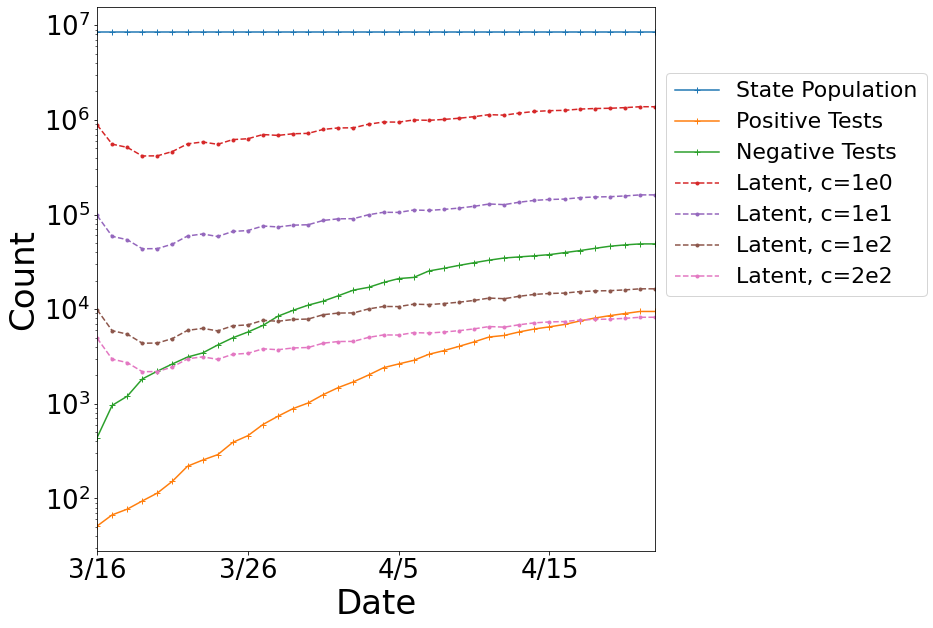

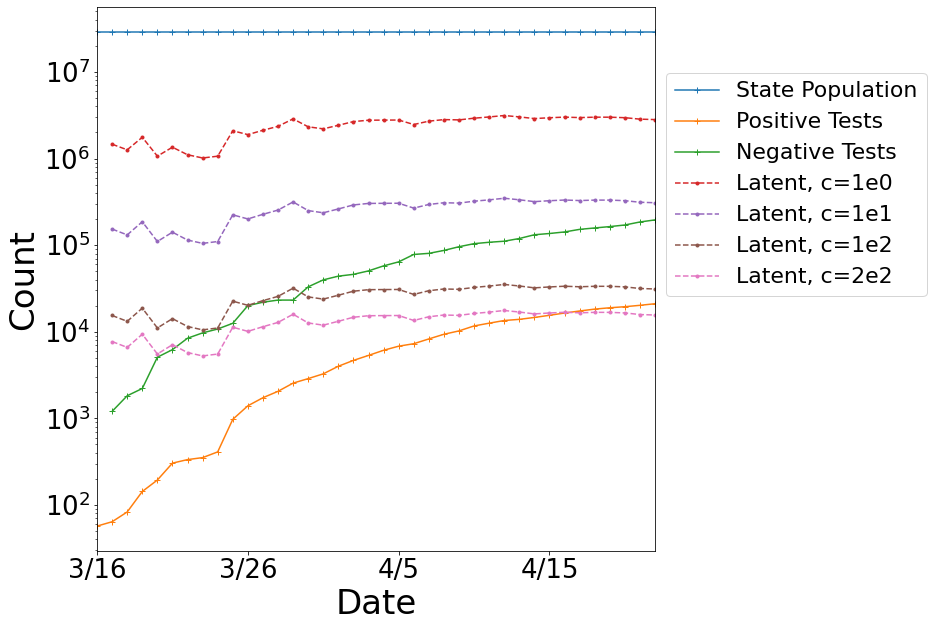

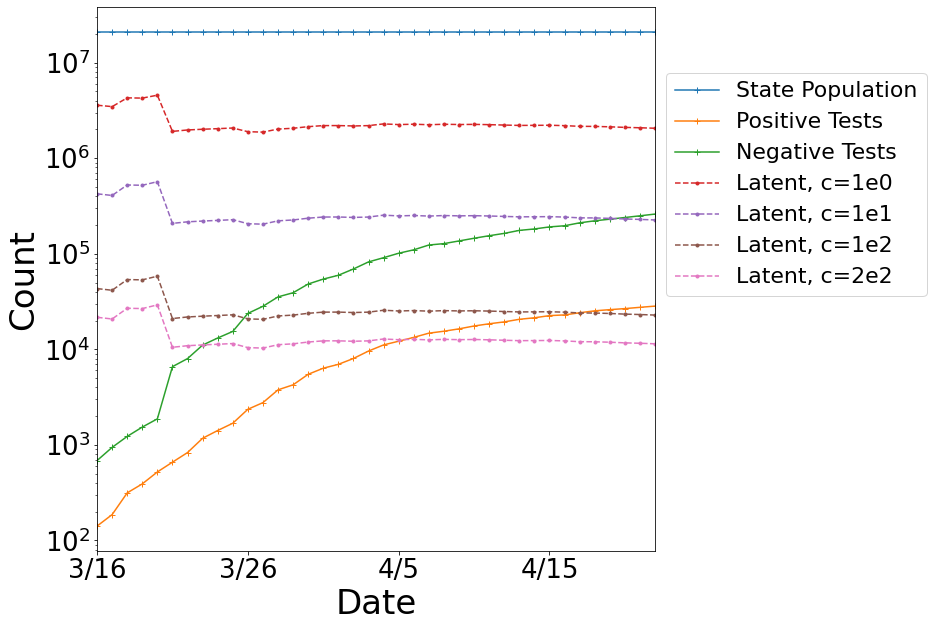

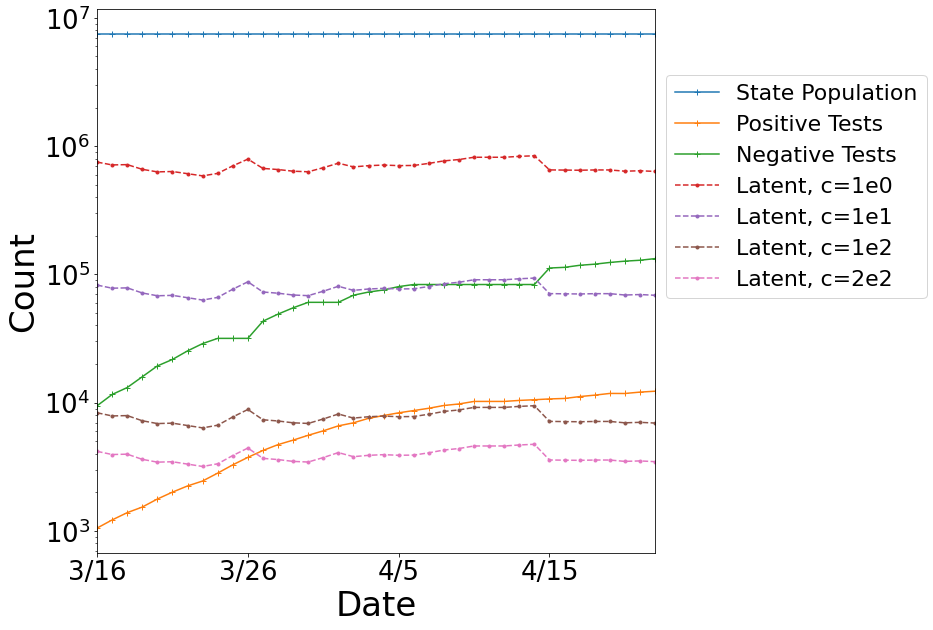

In [7]:
def plot(state, cs):
    #dates = [get_date_format(d, 3, 2020) for d in range(begin_day, end_day+1)]
    
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    plt.semilogy(pop, label='State Population', marker='+')
    plt.semilogy(positives, label='Positive Tests', marker='+')
    plt.semilogy(negatives, label='Negative Tests', marker='+')
    markers = ['.', '+', '*', '^']
    i = 0
    for c_name, c_key in cs.items():
        latent_totals = np.array([
            get_latent_total(state, date, c_key) for date in dates])
        plt.semilogy(latent_totals, label='Latent, c={}'.format(c_name), linestyle='--',
                    marker=markers[i // 4])
        i += 1

    plt.xlim([0, len(dates)-1])
    
    locs, labels = plt.xticks()
    locs = locs[:-1]
    plt.xticks(locs, [readable_dates[int(i)] for i in locs])
    plt.xlabel("Date", fontsize=34)
    plt.ylabel("Count", fontsize=34)
    lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
    plt.savefig("results/Latent_Cases_{}.pdf".format(state), dpi=300, bbox_inches='tight', bbox_artists=[lgd])

for state in state_pops.keys():
    fig = plt.figure(figsize=(10, 10))
    plot(state, {'1e0': 1e0, 
                 '1e1': 1e1,
                 '1e2': 1e2,
                 '2e2': 2e2,
                 #"Max": lambda x,y,z: (x - y) / z,
                 #"0.75Max": lambda x,y,z: 0.75*(x-y)/z,
                 #"0.5Max": lambda x,y,z: 0.5*(x-y)/z,
                 #"0.25Max": lambda x,y,z: 0.25*(x-y)/z,
                 #"0.1Max": lambda x,y,z: 0.1*(x-y)/z,
                }
        )

PA 0.1 [2667488.44489024] [1.00915478]
PA 0.5 [640236.68671619] [1.01098642]
PA 1.0 [328329.61944017] [1.01126823]
NY 0.1 [7594590.97483355] [1.00639183]
NY 0.5 [2206360.46158275] [1.00928468]
NY 1.0 [1169333.32882008] [1.00984144]
CA 0.1 [3070275.30508377] [0.70295677]
CA 0.5 [654770.51936842] [0.68326106]
CA 1.0 [330121.38309515] [0.68061391]
MD 0.1 [1180422.25994767] [1.0228696]
MD 0.5 [280182.23095818] [1.02714137]
MD 1.0 [143440.23250854] [1.02779023]
VA 0.1 [1403877.92150067] [1.02202739]
VA 0.5 [323522.51253076] [1.02538096]
VA 1.0 [164899.41347492] [1.02587335]
TX 0.1 [2878618.88578196] [1.01193154]
TX 0.5 [625385.77143358] [1.01296076]
TX 1.0 [316101.25166722] [1.01310203]
FL 0.1 [2103609.78734319] [1.01180164]
FL 0.5 [457374.84097158] [1.01282979]
FL 1.0 [231205.21689795] [1.01297104]
WA 0.1 [648881.39972683] [1.01194481]
WA 0.5 [139426.55150822] [1.01283304]
WA 1.0 [70367.34752775] [1.01295344]


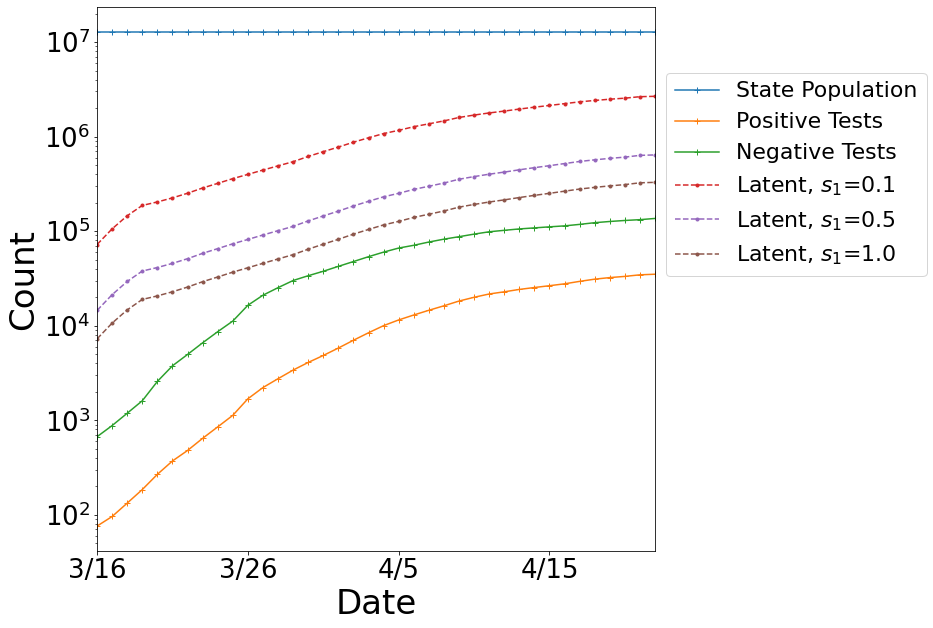

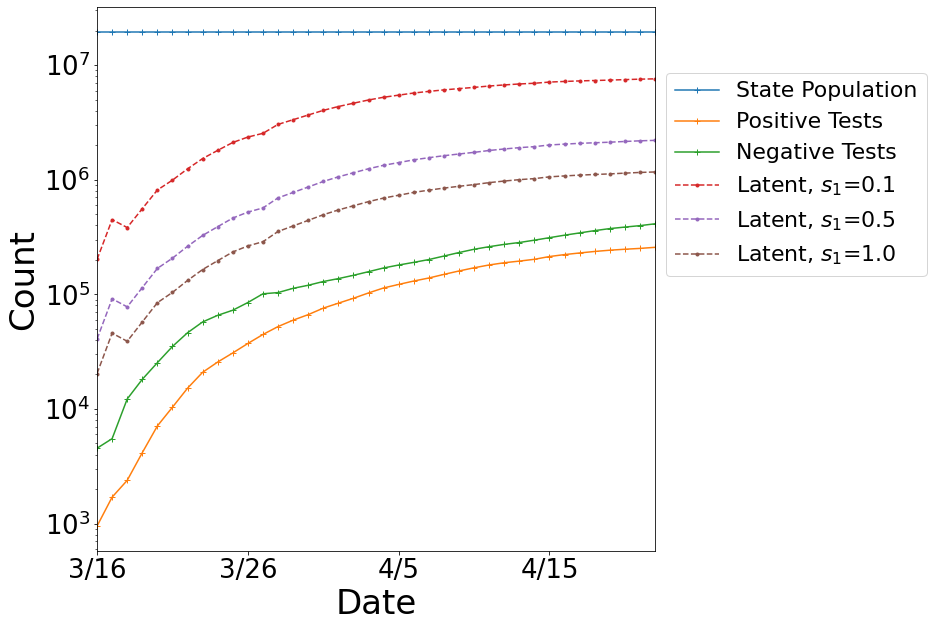

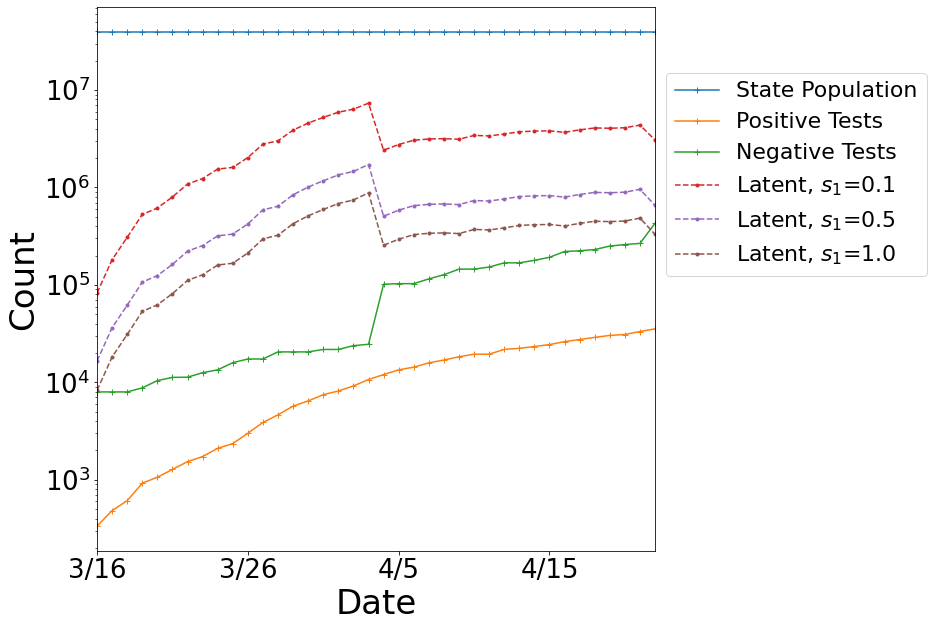

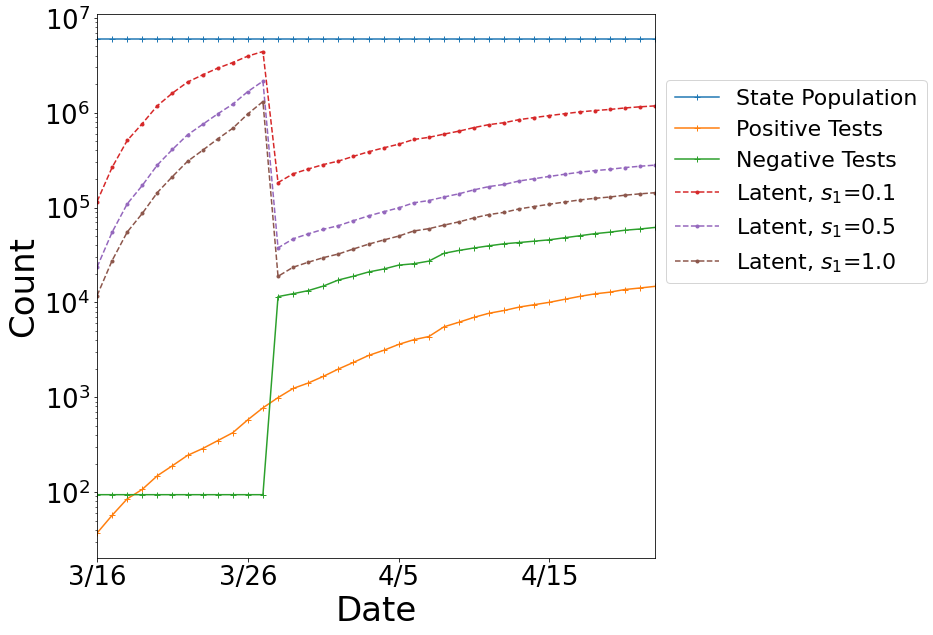

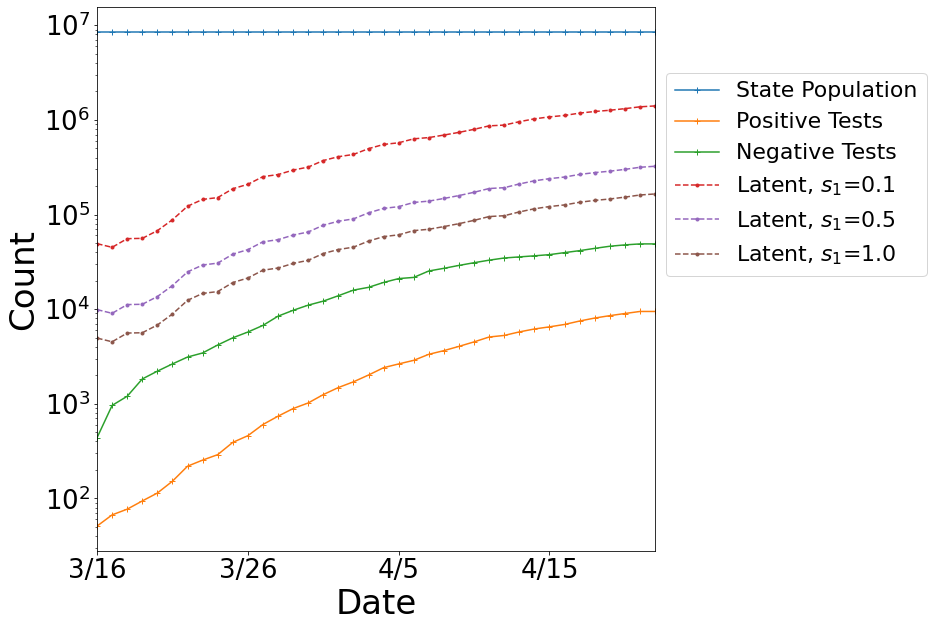

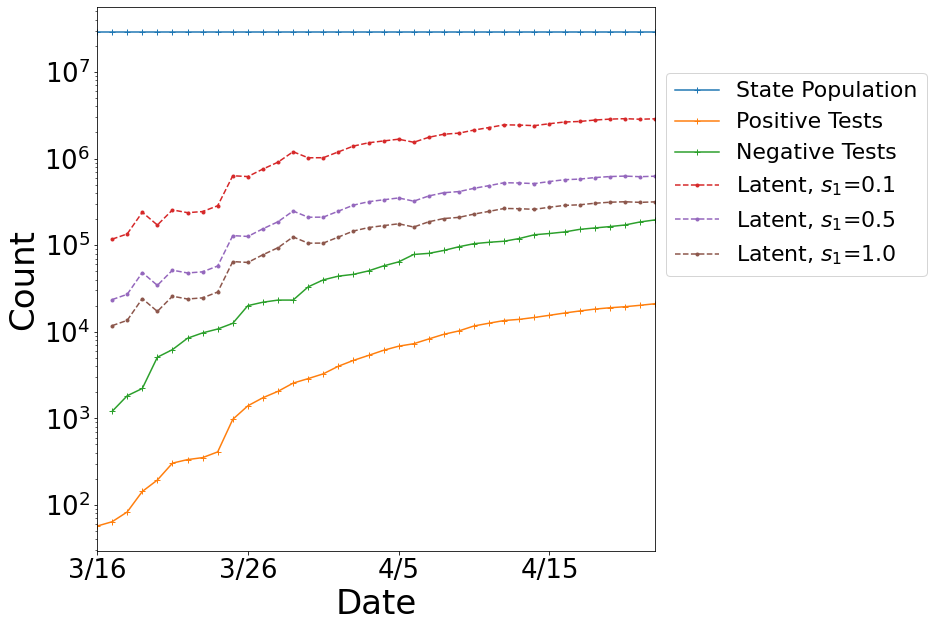

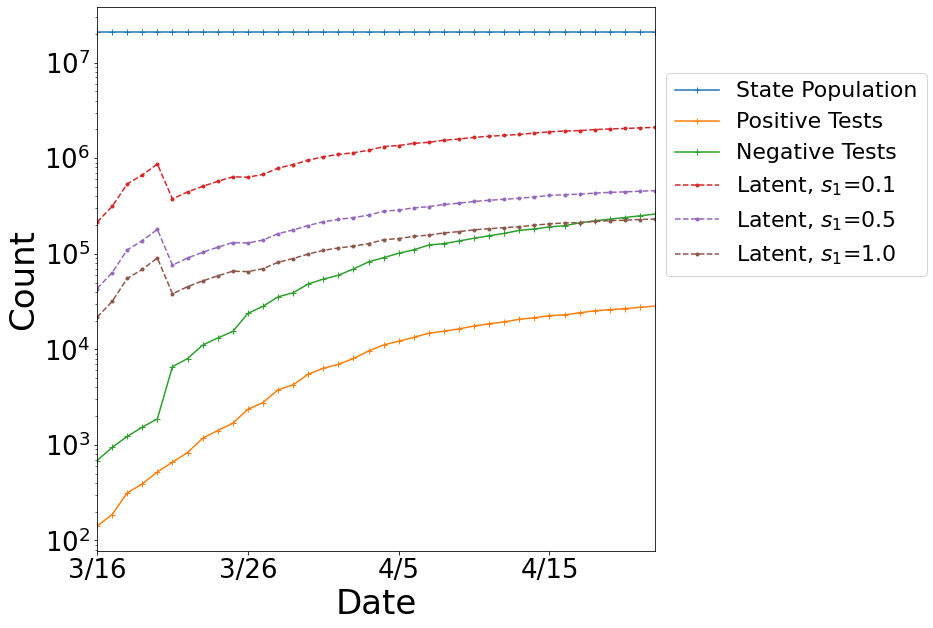

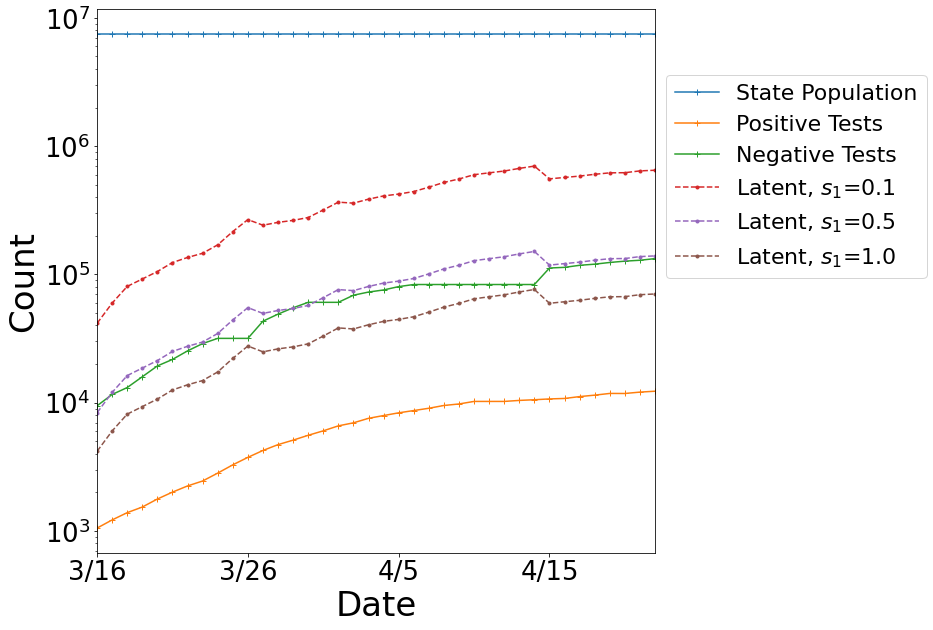

In [8]:
# flu-like symptoms
# common cold symptoms
def plot_s1s(state, s0, s1s):
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    plt.semilogy(pop, label='State Population', marker='+')
    plt.semilogy(positives, label='Positive Tests', marker='+')
    plt.semilogy(negatives, label='Negative Tests', marker='+')
    markers = ['.', '+', '*', '^']
    
    s0s = []
    n_dates = len(dates)
    for i, date in enumerate(dates):
        s0s.append(0.005 + i*(0.105 - 0.005)/n_dates)
        
    i = 0
    for s1_name, s1_key in s1s.items():
        latent_totals = np.array([
            get_latent_total(state, date, s1_key/s0) for date, s0 in zip(dates, s0s)])
        print(state, s1_name, latent_totals[-1], float(latent_totals[-1]) / latent_totals[-2])
        plt.semilogy(latent_totals, label='Latent, $s_1$={}'.format(s1_name), linestyle='--',
                    marker=markers[i // 4])
        i += 1
    plt.xlim([0, len(dates)-1])
    locs, labels = plt.xticks()
    locs = locs[:-1]
    plt.xticks(locs, [readable_dates[int(i)] for i in locs])
    plt.xlabel("Date", fontsize=34)
    plt.ylabel("Count", fontsize=34)
    lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
    plt.savefig("results/Latent_Cases_s1_s0_dynamic_{}.pdf".format(state), dpi=300, bbox_inches='tight', bbox_artists=[lgd])
    #'{:.4f}'.format(s0).replace('.'
    
s0_flu = 0.005
s0_cold = 0.105
for state in state_pops.keys():
    fig = plt.figure(figsize=(10, 10))
    plot_s1s(state, s0_cold, {#'0.01': 0.01, 
                 '0.1': 0.1,
                 '0.5': 0.5,
                 '1.0': 1.0,
                 #"Max": lambda x,y,z: (x - y) / z,
                 #"0.75Max": lambda x,y,z: 0.75*(x-y)/z,
                 #"0.5Max": lambda x,y,z: 0.5*(x-y)/z,
                 #"0.25Max": lambda x,y,z: 0.25*(x-y)/z,
                 #"0.1Max": lambda x,y,z: 0.1*(x-y)/z,
                }
        )

PA
NY
CA
MD
VA
TX
FL
WA


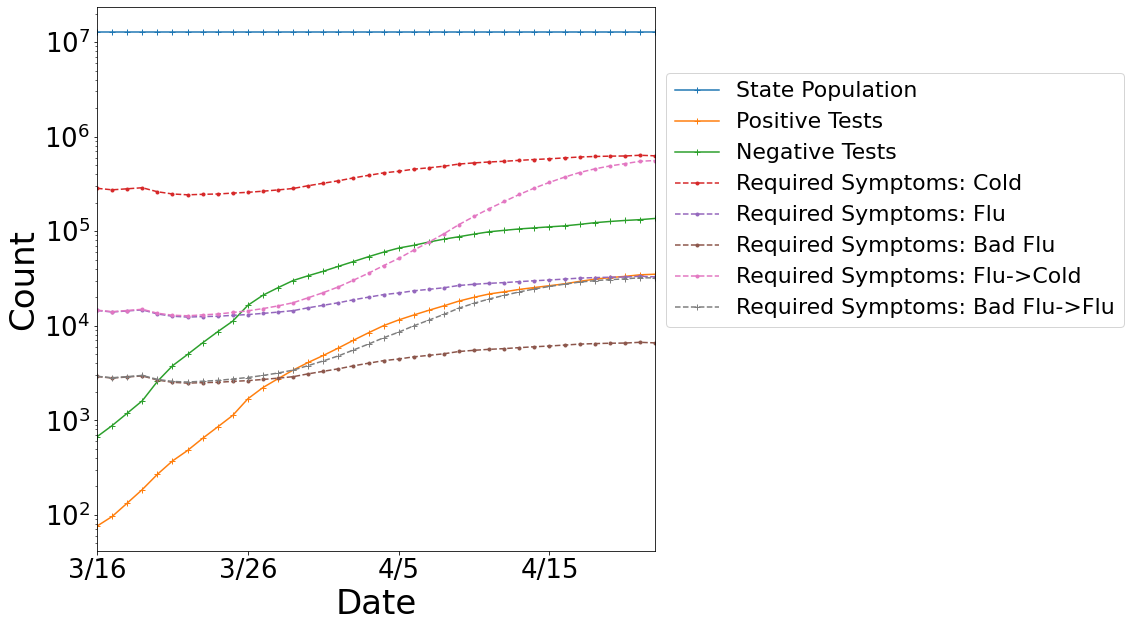

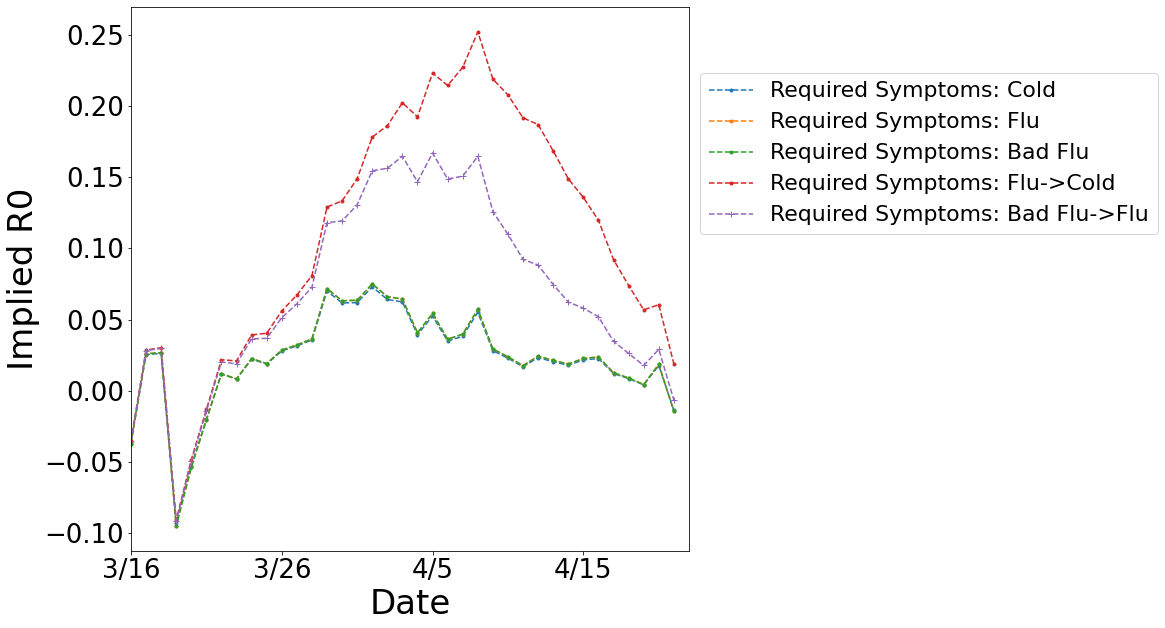

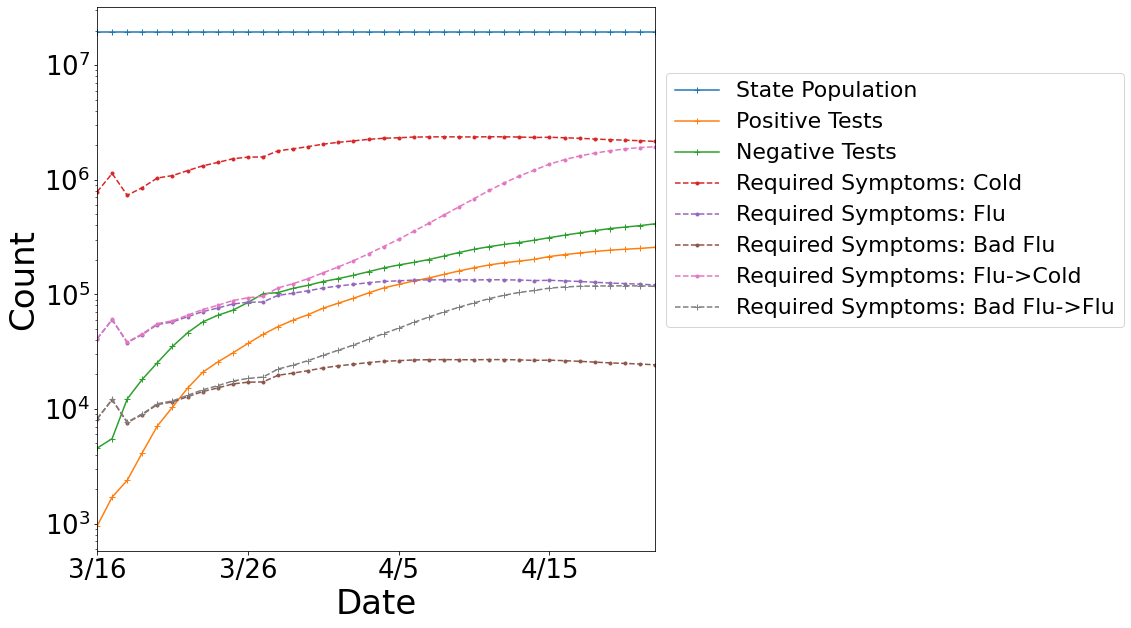

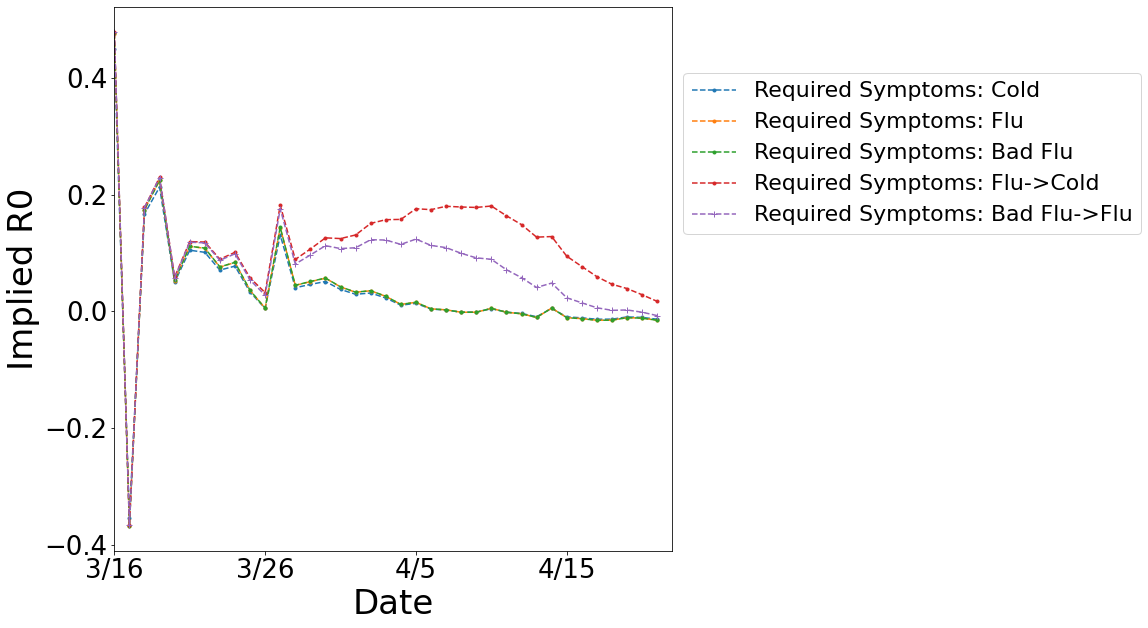

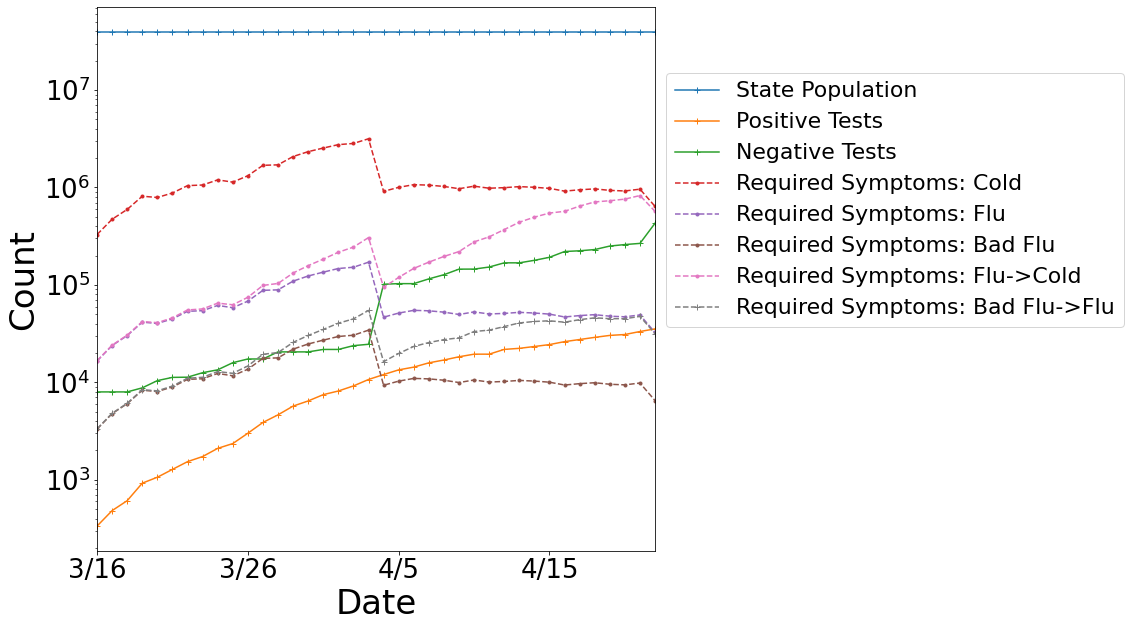

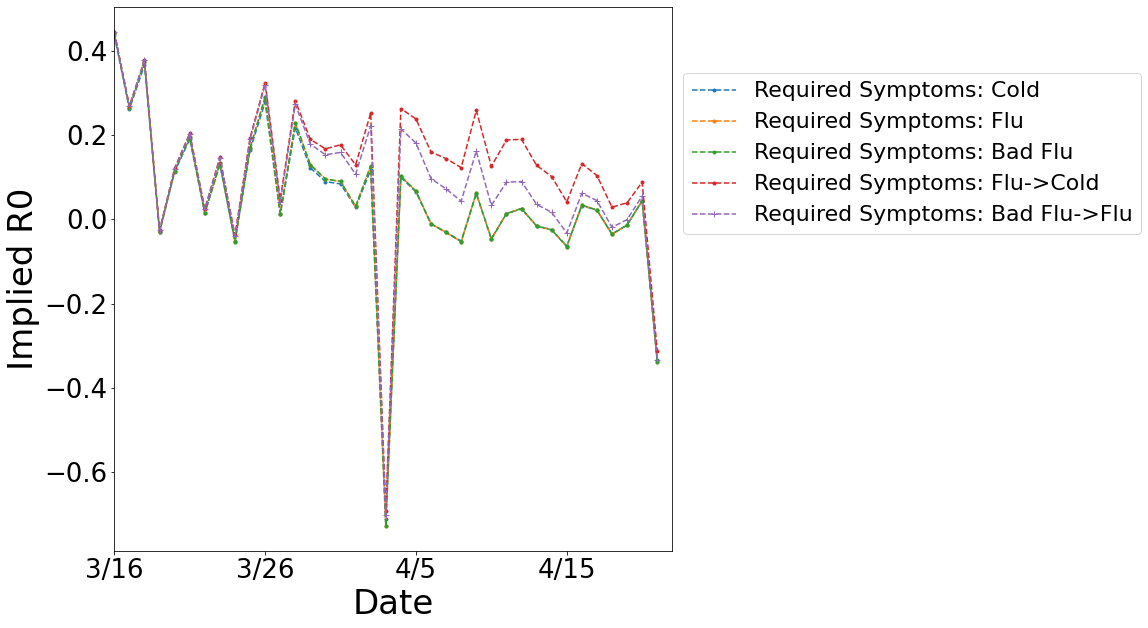

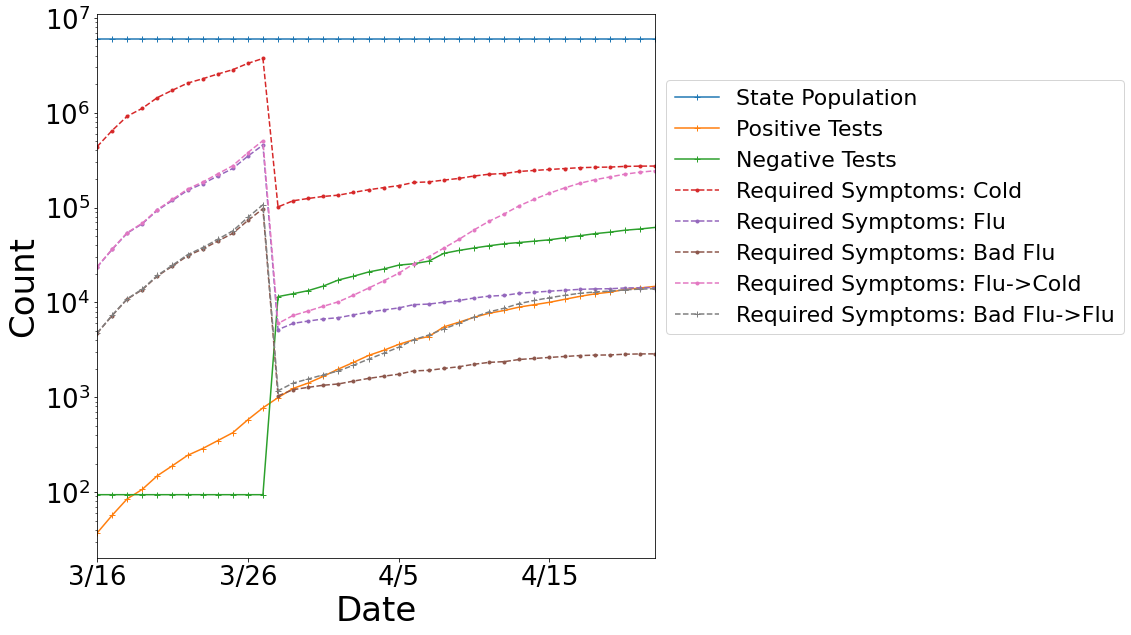

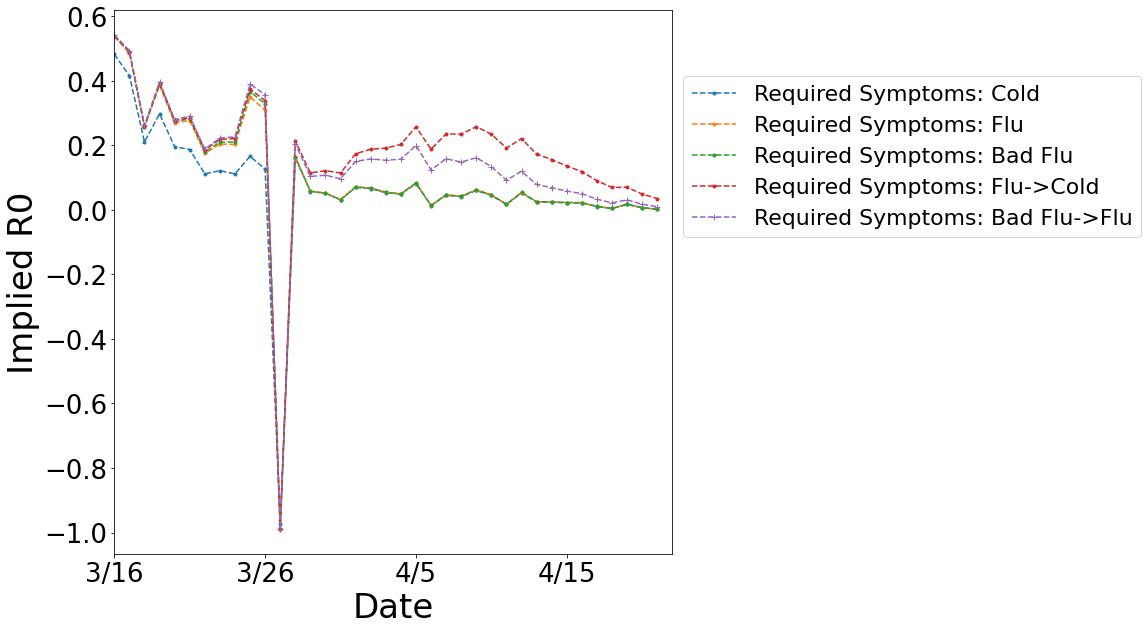

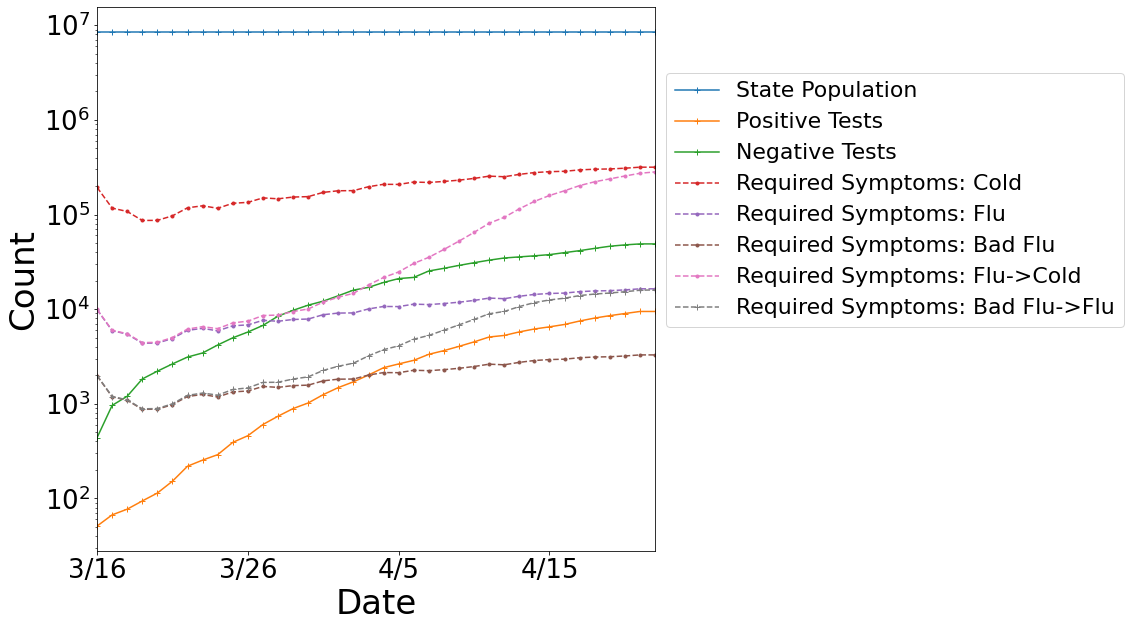

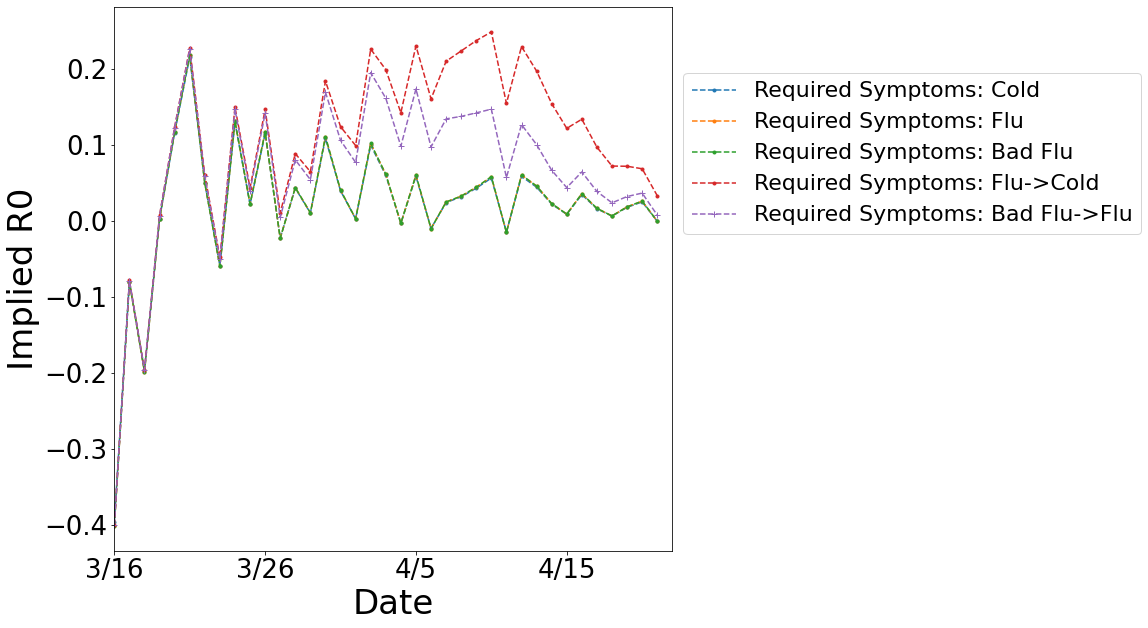

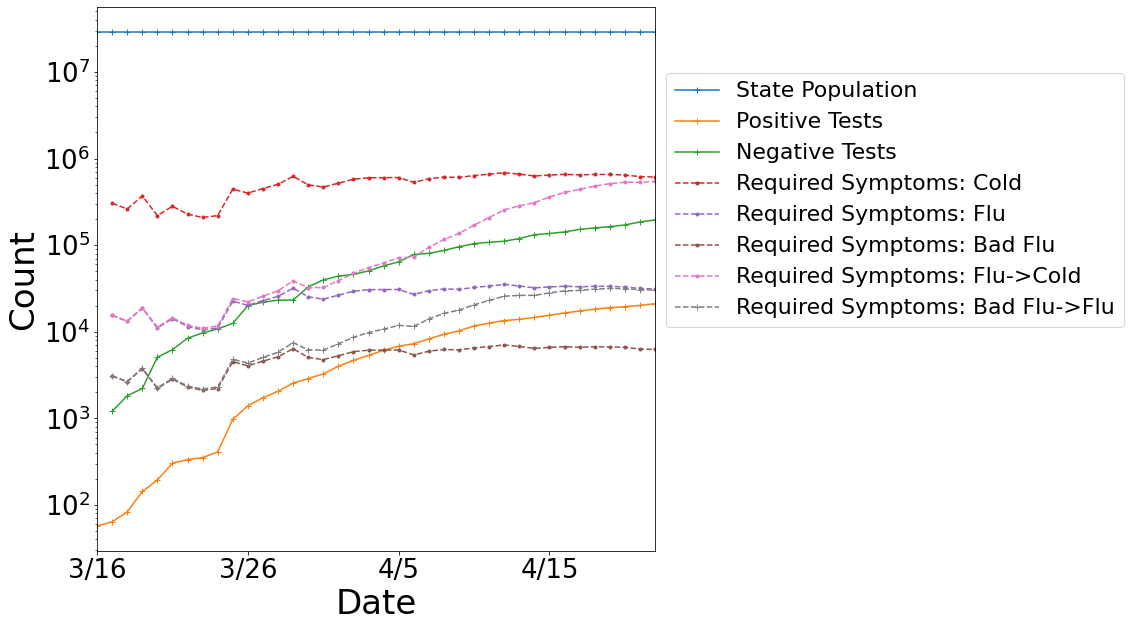

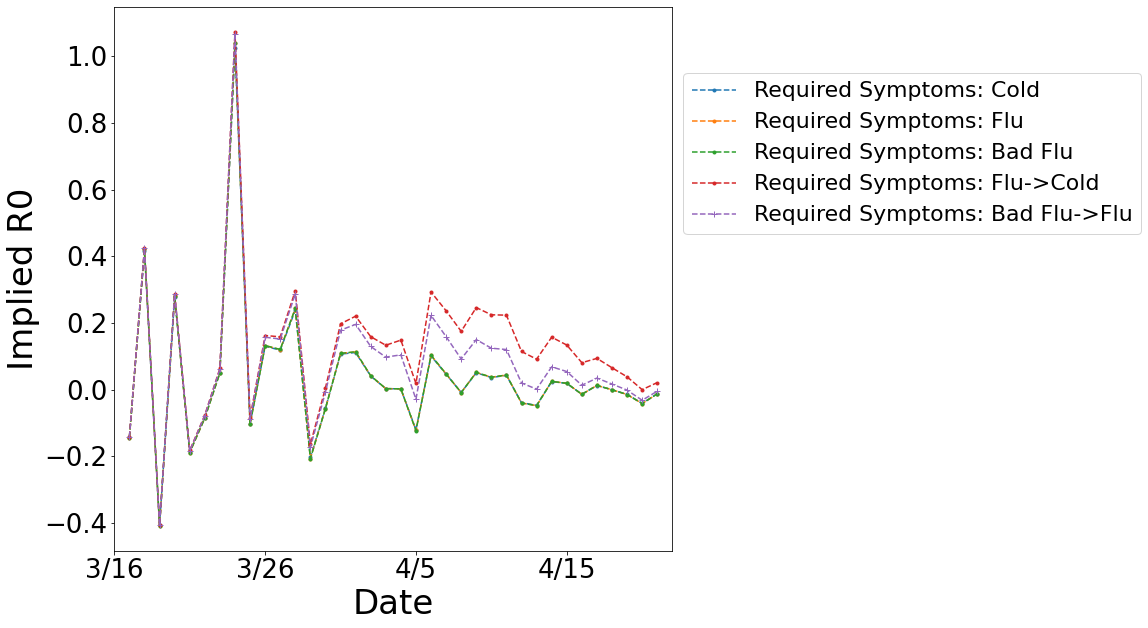

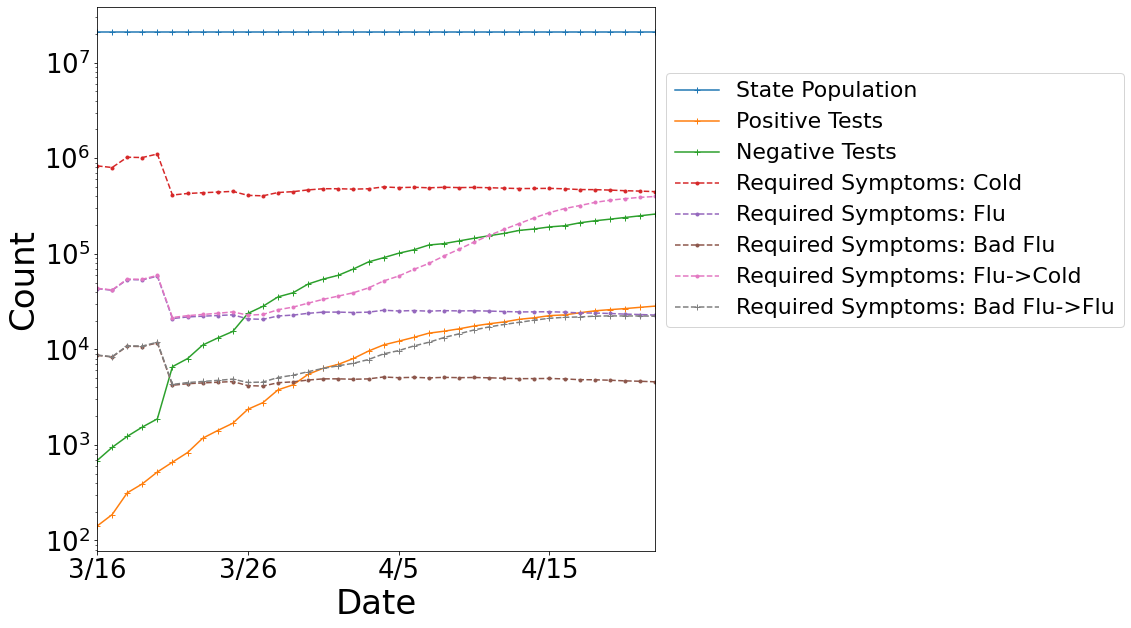

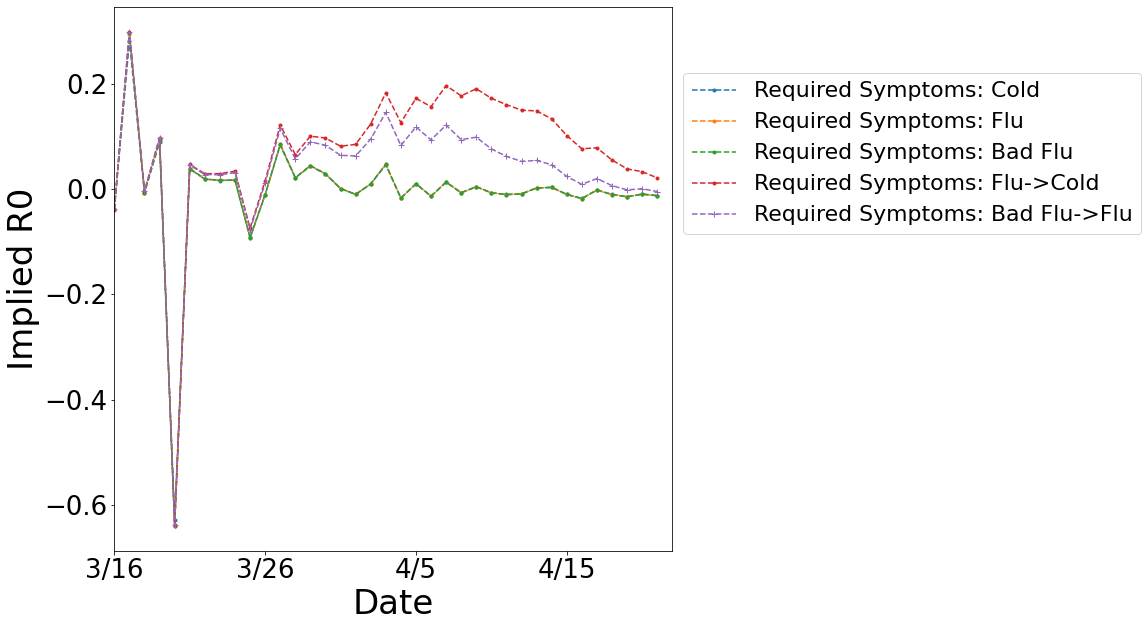

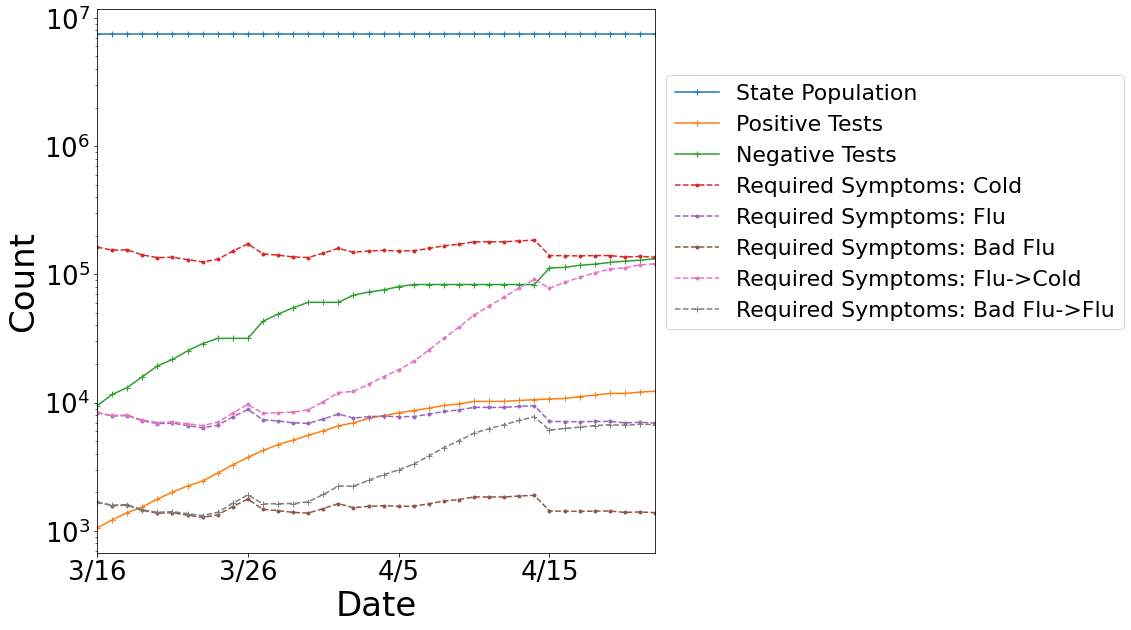

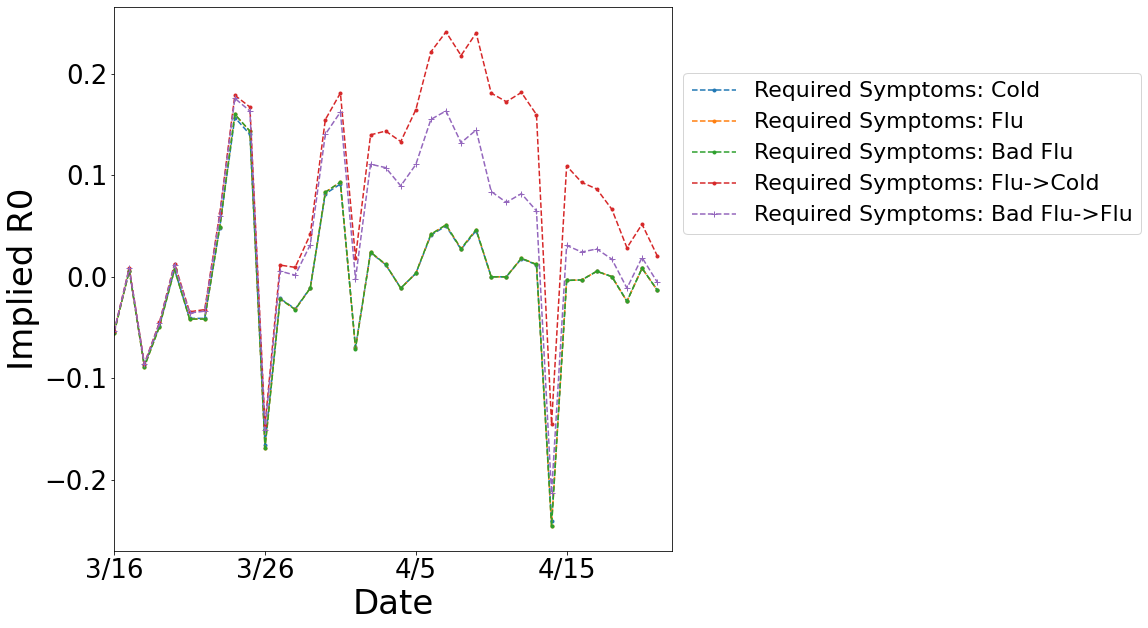

In [9]:
def plot(state, cs):
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    plt.semilogy(pop, label='State Population', marker='+')
    plt.semilogy(positives, label='Positive Tests', marker='+')
    plt.semilogy(negatives, label='Negative Tests', marker='+')
    markers = ['.', '+', '*', '^']
    i = 0
    for c_name, c_key in cs.items():
        try: 
            latent_totals = np.array([
                get_latent_total(state, date, c_key(j)) for j, date in enumerate(dates)])
        except:
            latent_totals = np.array([
                get_latent_total(state, date, c_key) for j, date in enumerate(dates)])
        plt.semilogy(latent_totals, label='{}'.format(c_name), linestyle='--',
                    marker=markers[i // 4])
        i += 1

    plt.xlim([0, len(dates)-1])
    
    locs, labels = plt.xticks()
    locs = locs[:-1]
    plt.xticks(locs, [readable_dates[int(i)] for i in locs])
    plt.xlabel("Date", fontsize=34)
    plt.ylabel("Count", fontsize=34)
    lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
    plt.savefig("results/Latent_Cases_cold_flu_{}.pdf".format(state), dpi=300, bbox_inches='tight', bbox_artists=[lgd])

def plot_ros(state, cs):
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    #plt.semilogy(pop, label='State Population', marker='+')
    #plt.semilogy(positives, label='Positive Tests', marker='+')
    #plt.semilogy(negatives, label='Negative Tests', marker='+')
    markers = ['.', '+', '*', '^']
    i = 0
    for c_name, c_key in cs.items():
        try: 
            latent_totals = np.array([
                get_latent_total(state, date, c_key(j)) for j, date in enumerate(dates)])
        except:
            latent_totals = np.array([
                get_latent_total(state, date, c_key) for j, date in enumerate(dates)])
        plt.plot((latent_totals[1:]-latent_totals[:-1])/latent_totals[:-1], label='{}'.format(c_name), linestyle='--',
                    marker=markers[i // 4])
        i += 1

    plt.xlim([0, len(dates)-1])
    
    locs, labels = plt.xticks()
    locs = locs[:-1]
    plt.xticks(locs, [readable_dates[int(i)] for i in locs])
    plt.xlabel("Date", fontsize=34)
    plt.ylabel("Implied R0", fontsize=34)
    lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
    plt.savefig("results/R0s_cold_flu_{}.pdf".format(state), dpi=300, bbox_inches='tight', bbox_artists=[lgd])

def logistic(x_min, x_max, y_min, y_max, j):
    x_range = x_max - x_min
    x_mid = (x_max + x_min) / 2
    return y_min + (y_max-y_min)*(1 / (1 + np.exp(-10*(j - x_mid)/x_range)))

for state in state_pops.keys():
    fig = plt.figure(figsize=(10, 10))
    try:
        plot(state, {'Required Symptoms: Cold': 5, 
                     'Required Symptoms: Flu': 100,
                     'Required Symptoms: Bad Flu': 500,
                     'Required Symptoms: Flu->Cold': lambda j: logistic(0, len(dates)-1, 100, 5, j),#100 - j*(100-5)/(len(dates)-1),
                     #'Required Symptoms: Flu->2*Cold': lambda j: 100 - j*(100-10)/(len(dates)-1),
                     #'Required Symptoms: 2*Flu->2*Cold': lambda j: 200 - j*(200-10)/(len(dates)-1),
                     'Required Symptoms: Bad Flu->Flu': lambda j: logistic(0, len(dates)-1, 500, 100, j), #lambda j: 1000 - j*(1000-100)/(len(dates)-1),
                     #'Required Symptoms: 10*Flu->2*Flu': lambda j: 1000 - j*(1000-200)/(len(dates)-1)
                    }
            )
        fig = plt.figure(figsize=(10, 10))
        plot_ros(state, {'Required Symptoms: Cold': 5, 
                     'Required Symptoms: Flu': 100,
                     'Required Symptoms: Bad Flu': 500,
                     'Required Symptoms: Flu->Cold': lambda j: logistic(0, len(dates)-1, 100, 5, j),#100 - j*(100-5)/(len(dates)-1),
                     #'Required Symptoms: Flu->2*Cold': lambda j: 100 - j*(100-10)/(len(dates)-1),
                     #'Required Symptoms: 2*Flu->2*Cold': lambda j: 200 - j*(200-10)/(len(dates)-1),
                     #'Required Symptoms: Bad Flu->Flu': lambda j: 500 - j*(500-100)/(len(dates)-1),
                     'Required Symptoms: Bad Flu->Flu': lambda j: logistic(0, len(dates)-1, 500, 100, j), #lambda j: 1000 - j*(1000-100)/(len(dates)-1),
                     #'Required Symptoms: 10*Flu->2*Flu': lambda j: 1000 - j*(1000-200)/(len(dates)-1)
                    }
            )
        print(state)
    except KeyError:
        continue